<hr>
<h1 align="center">
  Introduction to Neural Networks
</h1>
<hr>


<h2>Mathematical Formalization</h2>

<h3>Dataset</h3>

1. Purpose of training, validation, and test sets:
   - Training: Used to train the model by updating weights.
   - Validation: Used to tune hyperparameters and avoid overfitting.
   - Test: Used to evaluate the final performance of the model.


2.  Influence of the number of examples (N):
    - A larger N generally improves the generalization of the model by providing more data to learn patterns.
    - Smaller N can lead to overfitting and poor generalization.


<h3>Network Architecture (Forward Phase)</h3>

3. Importance of activation functions:
   - They introduce non-linearity, enabling the network to learn complex patterns.


4.  Sizes (nx, nh, ny) in Figure 1:
    - nx: Input size, nh: Hidden layer size, ny: Output size.
    - These sizes depend on the data features and problem requirements.


5.  ${y}$ vs. $\hat{y}$:
    - ${y}$: Ground truth label.
    - $\hat{y}$: Model prediction. Difference between them is captured by the loss function.


6.  SoftMax usage:
    - Converts raw outputs into probabilities summing to 1, useful for classification.


7.  Forward equations:
    - $\tilde{h}$ = ${W_h}$ $\cdot$ ${x}$ + ${b_h}$
    - ${h}$ = $\tanh$($\tilde{h}$)
    - $\tilde{y}$ = ${W_y}$ $\cdot$ ${h}$ + ${b_y}$
    - $\hat{y}$ = SoftMax($\tilde{y}$)


<h2>Implementation</h2>

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from struct import unpack
import matplotlib.pyplot as plt

In [132]:
def init_params(nx, nh, ny):
    params = {}
    params["Wh"] = torch.randn(nh, nx, requires_grad=True) * 0.3
    params["bh"] = torch.zeros(nh, requires_grad=True)
    params["Wy"] = torch.randn(ny, nh, requires_grad=True) * 0.3
    params["by"] = torch.zeros(ny, requires_grad=True)
    return params

In [133]:
def forward(params, X):
    outputs = {}
    outputs["h_tilde"] = torch.mm(X, params["Wh"].t()) + params["bh"]
    outputs["h"] = torch.tanh(outputs["h_tilde"])
    
    outputs["y_tilde"] = torch.mm(outputs["h"], params["Wy"].t()) + params["by"]
    exp_scores = torch.exp(outputs["y_tilde"])
    outputs["y_hat"] = exp_scores / exp_scores.sum(dim=1, keepdim=True)
    
    return outputs["y_hat"], outputs

In [134]:
def loss_accuracy(y_hat, y):
    loss = -torch.mean(torch.sum(y * torch.log(y_hat + 1e-10), dim=1))
    _, predicted = torch.max(y_hat, 1)
    _, true_classes = torch.max(y, 1)
    accuracy = (predicted == true_classes).float().mean()
    return loss, accuracy

In [135]:
def backward(params, outputs, Y):
    Yhat = torch.exp(outputs["y_pre"])
    Yhat /= torch.sum(Yhat, dim=1, keepdim=True)
    grad_y_pre = Yhat - Y
    grad_Wy = torch.mm(grad_y_pre.t(), outputs["h"])
    grad_by = torch.sum(grad_y_pre, dim=0)
    grad_h = torch.mm(grad_y_pre, params["Wy"])
    grad_h_pre = grad_h * (1 - outputs["h"] ** 2)
    grad_Wh = torch.mm(grad_h_pre.t(), X)
    grad_bh = torch.sum(grad_h_pre, dim=0)

    return {"Wy": grad_Wy, "by": grad_by, "Wh": grad_Wh, "bh": grad_bh}

In [136]:
def sgd(params, grads, eta):
    for key in params:
        params[key] -= eta * grads[key]

In [137]:
def init_model(nx, nh, ny, eta):
    model = nn.Sequential(
        nn.Linear(nx, nh),
        nn.Tanh(),
        nn.Linear(nh, ny),
        nn.Softmax(dim=1)
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta)
    return model, criterion, optimizer

In [138]:
def train(
    model, criterion, optimizer, train_loader, test_loader, epochs=10, batch_size=32
):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0
        num_batches = 0

        for i in range(0, len(train_loader[0]), batch_size):
            X_batch = train_loader[0][i : i + batch_size]
            y_batch = train_loader[1][i : i + batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)

            _, targets = torch.max(y_batch, 1)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == targets).float().mean()

            total_loss += loss.item()
            total_acc += accuracy.item()
            num_batches += 1

        model.eval()
        with torch.no_grad():
            test_outputs = model(test_loader[0])
            _, test_targets = torch.max(test_loader[1], 1)
            test_loss = criterion(test_outputs, test_targets)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_accuracy = (test_predicted == test_targets).float().mean()

        train_losses.append(total_loss / num_batches)
        test_losses.append(test_loss.item())
        train_accs.append(total_acc / num_batches)
        test_accs.append(test_accuracy.item())

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}")
        print(f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accs[-1]:.4f}")

    return train_losses, test_losses, train_accs, test_accs

<h2>Application on MNIST</h2>

In [139]:
def load_mnist(images_file, labels_file):
    with open(labels_file, "rb") as f:
        magic, n = unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)

    with open(images_file, "rb") as f:
        magic, num, rows, cols = unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(len(labels), 784)

    images = images.astype(np.float32) / 255.0
    labels_one_hot = np.zeros((labels.size, 10))
    labels_one_hot[np.arange(labels.size), labels] = 1

    return torch.FloatTensor(images), torch.FloatTensor(labels_one_hot)

In [140]:
train_images, train_labels = load_mnist(
    "./data/MNIST/train-images.idx3-ubyte", "./data/MNIST/train-labels.idx1-ubyte"
)
test_images, test_labels = load_mnist(
    "./data/MNIST/t10k-images.idx3-ubyte", "./data/MNIST/t10k-labels.idx1-ubyte"
)

In [141]:
nx = 784
nh = 128
ny = 10
eta = 0.01 

In [142]:
model, criterion, optimizer = init_model(nx, nh, ny, eta)
train_loader = (train_images, train_labels)
test_loader = (test_images, test_labels)
train_losses, test_losses, train_accs, test_accs = train(model, criterion, optimizer, train_loader, test_loader)


Epoch 1/10:
Train Loss: 2.1947, Train Acc: 0.4292
Test Loss: 2.0107, Test Acc: 0.5193
Epoch 2/10:
Train Loss: 1.8821, Train Acc: 0.6749
Test Loss: 1.7783, Test Acc: 0.7861
Epoch 3/10:
Train Loss: 1.7399, Train Acc: 0.8008
Test Loss: 1.7007, Test Acc: 0.8198
Epoch 4/10:
Train Loss: 1.6923, Train Acc: 0.8161
Test Loss: 1.6712, Test Acc: 0.8307
Epoch 5/10:
Train Loss: 1.6676, Train Acc: 0.8278
Test Loss: 1.6428, Test Acc: 0.8616
Epoch 6/10:
Train Loss: 1.6316, Train Acc: 0.8770
Test Loss: 1.6118, Test Acc: 0.8924
Epoch 7/10:
Train Loss: 1.6102, Train Acc: 0.8902
Test Loss: 1.5969, Test Acc: 0.8986
Epoch 8/10:
Train Loss: 1.5979, Train Acc: 0.8961
Test Loss: 1.5874, Test Acc: 0.9033
Epoch 9/10:
Train Loss: 1.5896, Train Acc: 0.9001
Test Loss: 1.5807, Test Acc: 0.9053
Epoch 10/10:
Train Loss: 1.5834, Train Acc: 0.9035
Test Loss: 1.5755, Test Acc: 0.9082


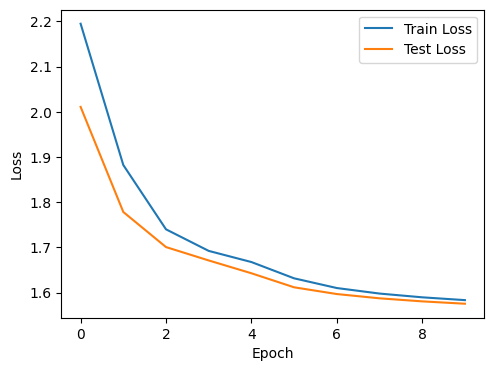

In [143]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

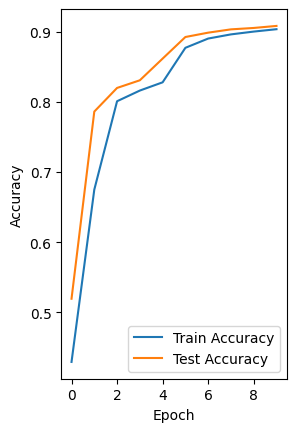

In [144]:
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h2>SVM</h2>

In [145]:
def train_svm_on_circles():
    np.random.seed(42)
    def make_circles(n_samples=1000, noise=0.1, factor=0.5):
        n = n_samples // 2
        theta = np.linspace(0, 2*np.pi, n)
        inner_x = factor * np.cos(theta)
        inner_y = factor * np.sin(theta)
        inner_labels = np.zeros(n)
        outer_x = np.cos(theta)
        outer_y = np.sin(theta)
        outer_labels = np.ones(n)
        X = np.vstack([
            np.column_stack([inner_x, inner_y]),
            np.column_stack([outer_x, outer_y])
        ])
        y = np.concatenate([inner_labels, outer_labels])
        X += np.random.normal(0, noise, X.shape)
        
        return X, y

    X, y = make_circles(n_samples=1000, noise=0.1)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    svm = SVC(kernel='rbf')
    svm.fit(X_train, y_train)
    
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
    plt.title('Training Data')
    
    plt.subplot(122)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
    plt.title(f'SVM Decision Boundary (Accuracy: {accuracy:.2f})')
    
    plt.tight_layout()
    plt.show()
    
    print(f"SVM Accuracy: {accuracy:.4f}")
    
    return svm



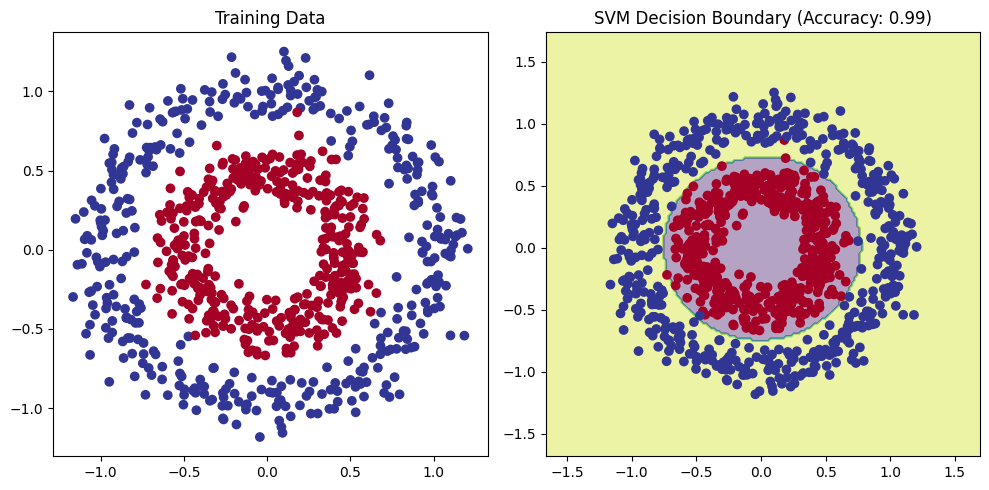

SVM Accuracy: 0.9950


In [146]:
svm_model = train_svm_on_circles()